In [3]:
# Preamble

from astropy.table import Table, column
import numpy as np
import os

%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
# better-looking plots
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.figsize'] = (10.0, 8)
plt.rcParams['font.size'] = 18
mpl.ticker.AutoLocator.default_params['nbins'] = 5
mpl.ticker.AutoLocator.default_params['prune'] = 'both'

mpl.rcParams['ps.useafm'] = True
mpl.rcParams['pdf.use14corefonts'] = True
mpl.rcParams['text.usetex'] = True

In [1]:
import sys
sys.path.append('../../../astro_codes/')
#------------------------------------

In [4]:
gz_data = Table.read('../matched_fits/gz_data.fits')
nsa_matched = Table.read('../matched_fits/nsa_matched.fits')
samples = Table.read('../matched_fits/samples.fits')
masks = Table.read('../matched_fits/bad_flux_mask.fits')
sfrs = Table.read('../matched_fits/sfr_table.fits')
chang_out_matched = Table.read('../matched_fits/chang_out_matched.fits')
print('Loaded all data.')

Loaded all data.


In [6]:
def select_star_forming(u,r,z,mask=None): # Chang+15
    N = len(u)
    star_forming = np.zeros(N)
    star_forming[u-r < 2.1] = 1
    star_forming[u-r < 1.6*(r-z)+1.1] = 1
    if mask is not None:
        star_forming[mask == False] = 0
    return star_forming.astype(bool)

In [7]:
u = nsa_matched['M_corrected'][:,2]
r = nsa_matched['M_corrected'][:,4]
z = nsa_matched['M_corrected'][:,6]
mask = (nsa_matched['mask']*masks['u']*masks['r']*masks['z'])

star_forming = select_star_forming(u,r,z,mask)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


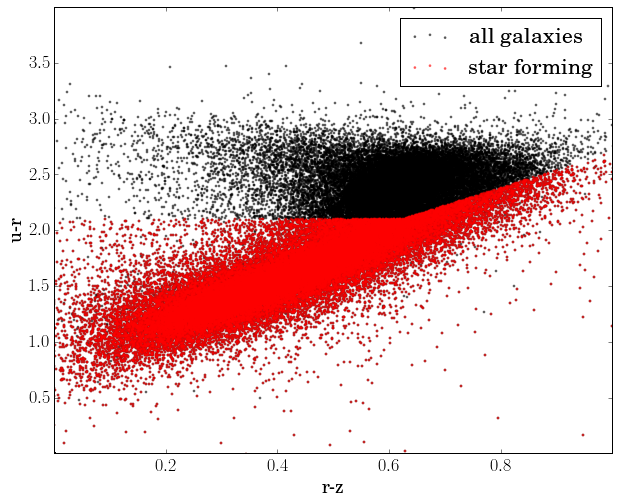

In [8]:
_ = plt.scatter(r-z,u-r,color='k',alpha=0.5,s=3,label='all galaxies')
_ = plt.axis((0,1,0,4))
_ = plt.scatter((r-z)[star_forming],(u-r)[star_forming],color='r',alpha=0.5,s=3,label='star forming')
_ = plt.legend()
plt.xlabel('r-z')
plt.ylabel('u-r')

In [9]:
samples['star_forming'] = star_forming
samples.write('../matched_fits/samples.fits',overwrite=True)

/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


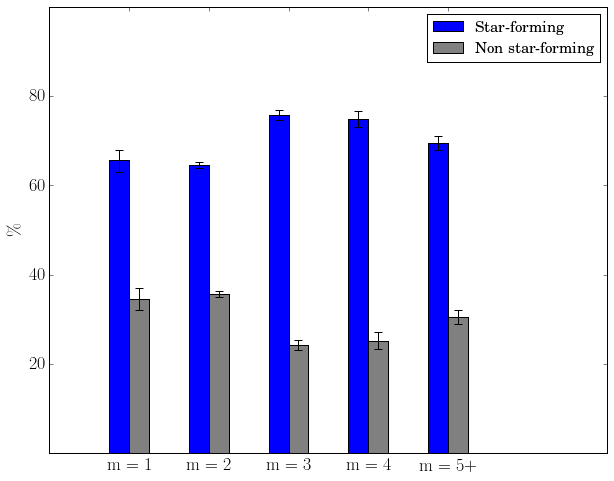

In [79]:
from bar_plots import comparison_bar_chart

in_vmax = samples['in_vmax_limit']
in_spiral = (samples['in_spiral']*samples['axial_ok']).astype(bool)
ok_sfr = (masks['w4']*masks['fuv']).astype(bool)

in_sample = (in_vmax*in_spiral).astype(bool)
spiral_m = samples['m'][in_sample]
spiral_sf = star_forming[in_sample]

labels = ['$\mathrm{m=1}$','$\mathrm{m=2}$','$\mathrm{m=3}$','$\mathrm{m=4}$','$\mathrm{m=5+}$']

# make the table- what fraction of galaxies are star forming as a function of arm number?

sf_fracs = Table()

for m in range(5):
    in_m = spiral_m == m
    sf = spiral_sf[in_m] == True
    non_sf = spiral_sf[in_m] == False
    sf_fracs[labels[m]] = [np.sum(sf),np.sum(non_sf)]
    
_ = comparison_bar_chart(sf_fracs,labels=['Star-forming','Non star-forming'],colors=['b','grey'],
                         normalise='percent',ylabel='$\%$',linewidth=1)

_ = plt.ylim(0,100)

In [60]:
from scipy.optimize import curve_fit

def plot_sfms(mass,sfr,weighting,color,line=True,xy_range=(9,11.5,-1,2)):
    
    def linear(x,m,c):
        return m*x + c
    
    ax = plt.gca()
    max_size = 20
    sizes = max_size*(weighting/np.max(weighting))
    _ = plt.scatter(mass,sfr,alpha=1,s=sizes,color=color)
    
    if line is True:
        p, _ = curve_fit(linear,mass,sfr,
                         sigma=weighting,absolute_sigma=False)
        x_guide = np.linspace(xy_range[0],xy_range[1],100)
        y_guide = linear(x_guide,*p)
        _ = plt.plot(x_guide,y_guide,color=color)

    _ = plt.axis(xy_range)
    return None

In [88]:
reference_sample = (in_vmax*ok_sfr*star_forming).astype(bool)
print('Reference sample: {} star-forming galaxies'.format(np.sum(reference_sample)))
spiral_sample = (in_vmax*in_spiral*ok_sfr*star_forming).astype(bool)
print('Spiral sample: {} star-froming galaxies'.format(np.sum(spiral_sample)))

Reference sample: 8094 star-forming galaxies
Spiral sample: 4040 star-froming galaxies


In [130]:
from scipy.stats import binned_statistic
from astroML.resample import bootstrap

def get_line(x,y,bins=12,ranges=None,use_bootstrap=False,percentiles=(16,84)):

    def percentile_function(x):
        lower = np.percentile(x,percentiles[0])
        median = np.median(x)
        upper = np.percentile(x,percentiles[1])
        return lower, median, upper
    
    if ranges == None:
        ranges = (np.min(x),np.max(x),np.min(y),np.max(y))
        
    if isinstance(bins, int) == True:
        bins = np.linspace(ranges[0],ranges[1],bins+1)
    xbin_centres = [bins[i]+(bins[i+1]-bins[i])/2 for i in range(len(bins)-1)]
    x_bins, _, bin_assignment = binned_statistic(x,x,bins=bins,statistic='median')
    
    x_medians = np.array([])
    x_uppers = np.array([])
    x_lowers = np.array([])
    y_medians = np.array([])
    y_uppers = np.array([])
    y_lowers = np.array([])
    for b in np.unique(bin_assignment):
        in_bin = bin_assignment == b
        x_bin = x[in_bin]
        y_bin = y[in_bin]
        
        if use_bootstrap == True:
            x_lower, x_median, x_upper = bootstrap(x_bin,10,percentile_function,random_state=0)
            y_lower, y_median, y_upper = bootstrap(y_bin,10,percentile_function,random_state=0)
        else:
            x_lower, x_median, x_upper = percentile_function(x_bin)
            y_lower, y_median, y_upper = percentile_function(y_bin)
        
        x_lowers = np.append(x_lowers,x_lower)
        x_medians = np.append(x_medians,x_median)
        x_uppers = np.append(x_uppers,x_upper)
        y_lowers = np.append(y_lowers,y_lower)
        y_medians = np.append(y_medians,y_median)
        y_uppers = np.append(y_uppers,y_upper)
            
    stats_table = Table()
    stats_table['x'] = x_medians
    stats_table['x_upper'] = x_uppers
    stats_table['x_lower'] = x_lowers
    stats_table['y'] = y_medians
    stats_table['y_upper'] = y_uppers
    stats_table['y_lower'] = y_lowers
    stats_table['x_centres'] = xbin_centres
    
    return stats_table, bins

In [155]:
from palettable.colorbrewer.sequential import Greys_9

def heatmap(x,y,x_bins,y_bins,colormap,colorbar=True,log_scale=False,
            xlabel='x',ylabel='y',zlabel='z',weights=None):
    if log_scale == True:
        h = plt.hist2d(x,y,weights=weights,bins=[x_bins,y_bins],
                       norm=mpl.colors.LogNorm(),cmap=colormap)
    else:
        h = plt.hist2d(x,y,bins=[x_bins,y_bins],cmap=colormap)
    
    return h

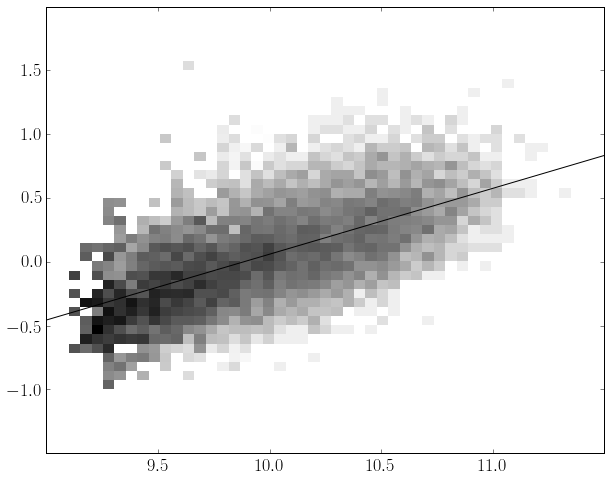

In [173]:
sfr = sfrs['total']
mass = chang_out_matched['lmass50_all']
vmax_weighting = samples['mass_weighting']

mass_reference, sfr_reference, w_reference = [s[reference_sample] for s in [mass,sfr,vmax_weighting]]

bin_edges = np.linspace(9,11.5,14)

xy_range = (9,11.5,-1,1.5)
xbins = np.linspace(9,11.5,50)
ybins = np.linspace(-1.5,2,50)

h = heatmap(mass_reference,sfr_reference,xbins,ybins,weights=w_reference,
            colormap=Greys_9.mpl_colormap,log_scale=True)

from scipy.optimize import curve_fit
def linear(x,m,c):
    return m*x + c 

p_reference, _ = curve_fit(linear,mass_reference,sfr_reference,sigma=w_reference)
x_guide = np.linspace(9,11.5,100)
plt.plot(x_guide,linear(x_guide,*p_reference),color='k')

In [178]:
from astropy.table import Table, column
import numpy as np
import math
import matplotlib.gridspec as gridspec
from contours import kde_contour

def make_figure(xlabel='x', ylabel='y'):
    fig = plt.figure(figsize=(10,10))
    gs = gridspec.GridSpec(3,3)
    ax0 = plt.subplot(gs[0,0:2])
    ax1 = plt.subplot(gs[1:,2])
    ax2 = plt.subplot(gs[1:,0:2])
    axarr = [ax0, ax1, ax2]
    plt.subplots_adjust(hspace=0,wspace=0)
    if xlabel != None:
        axarr[2].set_xlabel(xlabel)
    if ylabel != None:
        axarr[2].set_ylabel(ylabel)
    axarr[0].set_xticks([])
    axarr[0].set_yticks([])
    axarr[1].set_xticks([])
    axarr[1].set_yticks([])
    return fig, axarr


def histogram(data,bins,fill_properties,line_properties,
              fill=False,weights=None,normed=True,orientation='horizontal'):
    
    if fill == True:
        _ = plt.hist(data,bins,normed=normed,histtype='stepfilled',
                     weights=weights,orientation=orientation,
                     color=fill_properties['color'],
                     alpha=fill_properties['alpha'])
    
    _ = plt.hist(data,bins,normed=normed,histtype='step',
                 weights=weights,orientation=orientation,
                 color=line_properties['color'],
                 linewidth=line_properties['linewidth'],
                 linestyle=line_properties['linestyle'],
                 alpha=line_properties['alpha'])
    return None


def compare_xy_data(x,y,xy_range,N_bins,weights=None,xlabel='x',ylabel='y',
                    fill=False,contour_fill_properties=None,axarr=None,fig=None,
                    hist_fill_properties=None,line_properties=None,
                    bandwidth=None,levels=[0.2,0.4,0.6,0.8]):
  
    '''
    Inputs:
    ------
    x, y : x-data, y-data (list, array, column etc.)
    
    xy_range: tuple of 4-values (xmin,xmax,ymin,ymax).
    
    N_bins: tuple of (number of xbins, number of ybins)
    
    weights: weighting to each point, same length as x or y. Default is None,
    meaning that all points are weighted the same.
    
    xlabel,ylabel: labels for the axes
    
    fill: if True, then filled contours and histograms will be plotted.
   
    
    
    '''
    
    xmin, xmax, ymin, ymax = xy_range
    
    if xy_range == None:
        x_hist = x
        y_hist = y
        x_contour = x
        y_contour = y
        w_x, w_y, w_c = [weights, weights, weights]
    else:
        x_ok = (x >= xmin) & (x <= xmax)
        y_ok = (y >= ymin) & (y <= ymax)
        x_hist = x[x_ok]
        y_hist = y[y_ok]
        x_contour = x[(x_ok) & (y_ok)]
        y_contour = y[(x_ok) & (y_ok)]
        if weights != None:
            w_x = weights[x_ok]
            w_y = weights[y_ok]
            w_c = weights[(x_ok) & (y_ok)]
        else:
            w_x, w_y, w_c = [None,None,None]
    
    c_fp = {'colormap':'Greys',
           'alpha':0.5}  

    h_fp = {'color':'k',
            'alpha':0.5}
    
    lp = {'color':'k',
          'alpha':1,
          'linewidth':1,
          'linestyle':'solid'}
    
    if line_properties != None:
        for l in line_properties.keys():
            lp[l] = line_properties[l]
    if hist_fill_properties != None:
        for f in hist_fill_properties.keys():
            h_fp[f] = hist_fill_properties[f]
    if contour_fill_properties != None:
        for f in contour_fill_properties.keys():
            c_fp[f] = contour_fill_properties[f]
    
    x_bins = np.linspace(xy_range[0],xy_range[1],N_bins[0]+1)
    y_bins = np.linspace(xy_range[2],xy_range[3],N_bins[1]+1)
    
    if axarr == None:
        fig, axarr = make_figure(xlabel,ylabel)
    
    plt.sca(axarr[0])
    _ = histogram(x_hist,x_bins,h_fp,lp,fill,weights=w_x,orientation='vertical')
    plt.sca(axarr[1])
    _ = histogram(y_hist,y_bins,h_fp,lp,fill,weights=w_y)
    plt.sca(axarr[2])
    #_ = plt.scatter(x_contour,y_contour,alpha=0.01)
    _ = kde_contour(x_contour,y_contour,xy_range,bandwidth,fill,c_fp,lp,levels,weights=w_c)
    bandwidth = _[-1]
    
    axarr[0].set_xlim(xmin,xmax)
    axarr[1].set_ylim(ymin,ymax)
    axarr[2].axis((xmin,xmax,ymin,ymax))
    
    return fig, axarr, bandwidth

/home/ppxrh/anaconda3/lib/python3.4/site-packages/astropy/table/column.py:271: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return self.data.__ne__(other)
/home/ppxrh/anaconda3/lib/python3.4/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype >f8 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/ppxrh/anaconda3/lib/python3.4/site-packages/astropy/table/column.py:271: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  return self.data.__ne__(other)
/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:631: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/home/ppxrh/anaconda3/lib/python3.4/site-packages/sklearn/utils/validation.py:420: DataConversionWar

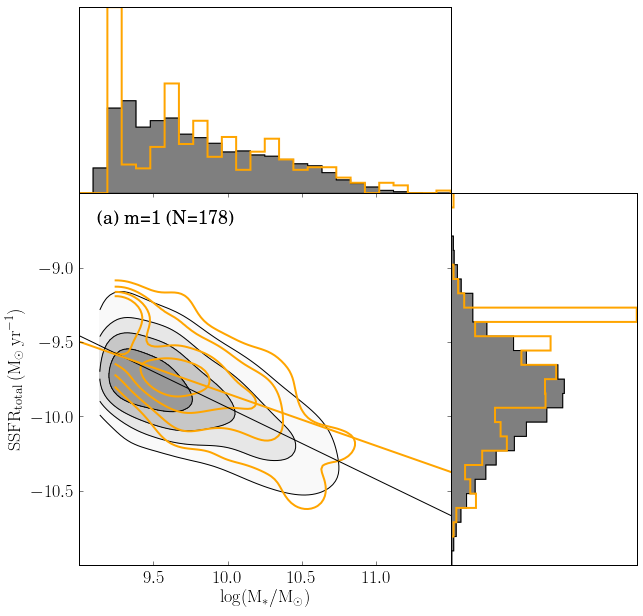

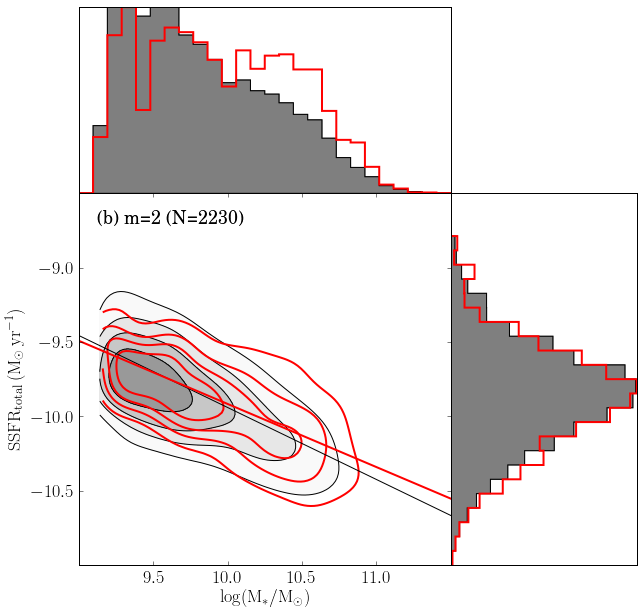

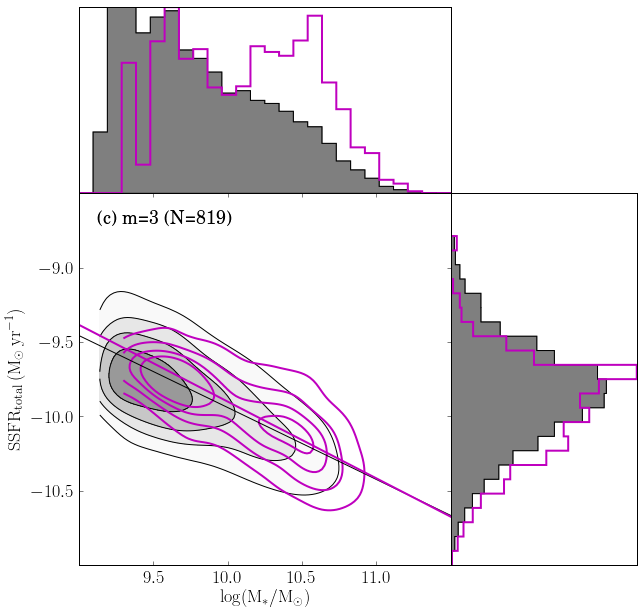

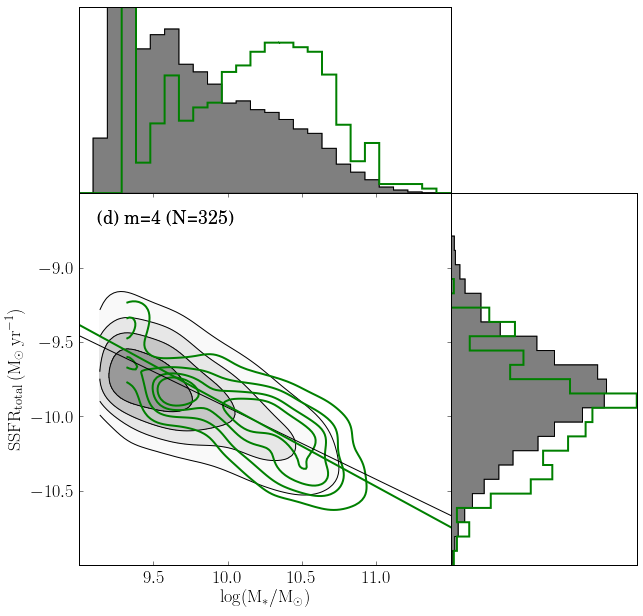

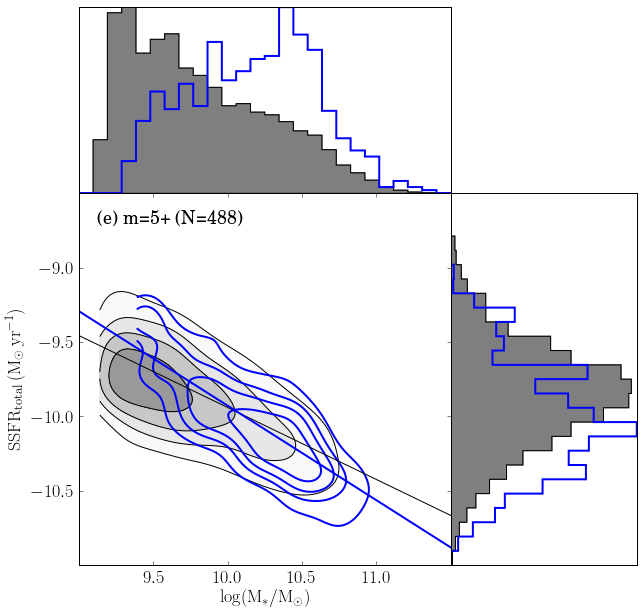

In [212]:
#from compare_xy import compare_xy_data
xy_range = (9,11.5,-1,1.5)
xy_range = (9,11.5,-11,-8.5)

sfr = sfrs['total'] - chang_out_matched['lmass50_all']
mass = chang_out_matched['lmass50_all']
vmax_weighting = samples['mass_weighting']

mass_reference, sfr_reference, w_reference = [s[reference_sample] for s in [mass,sfr,vmax_weighting]]
p_reference, _ = curve_fit(linear,mass_reference,sfr_reference,sigma=w_reference)

bandwidth = None

figlabels = 'abcdef'
mlabels = ['1','2','3','4','5+']
colors = ['orange','r','m','g','b']
line_properties = {'linewidth':2}

x_guide = np.linspace(xy_range[0],xy_range[1])

for m in range(5):
    
    fig, axarr, bandwidth = compare_xy_data(mass_reference,sfr_reference,xy_range,bandwidth=bandwidth,
                                            N_bins=(26,26),weights=w_reference,fill=True)

    in_m = (spiral_sample*(samples['m'] == m)).astype(bool)
    mass_data, sfr_data, w_data = [s[in_m] for s in [mass,sfr,vmax_weighting]]
    line_properties['color'] = colors[m]
    _ = compare_xy_data(mass_data,sfr_data,xy_range,bandwidth=bandwidth,fig=fig,axarr=axarr,
                        N_bins=(26,26),weights=w_data,line_properties=line_properties)
    
    p_data, _ = curve_fit(linear,mass_data,sfr_data)
    _ = plt.plot(x_guide,linear(x_guide,*p_reference),color='k',lw=1)
    _ = plt.plot(x_guide,linear(x_guide,*p_data),color=colors[m],lw=2)
    _ = axarr[2].text(0.05,0.95,'({}) m={} (N={})'.format(figlabels[m],mlabels[m],len(mass_data)),
                      transform=axarr[2].transAxes,ha='left',va='top')
    _ = axarr[2].set_xlabel('$\mathrm{\log(M_*/M_\odot)}$')
    _ = axarr[2].set_ylabel('$\mathrm{SSFR_{total} \, (M_\odot \, yr^{-1})}$')
    fig.savefig('../output_figures/sfms_{}.pdf'.format(mlabels[m]))

/home/ppxrh/anaconda3/lib/python3.4/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


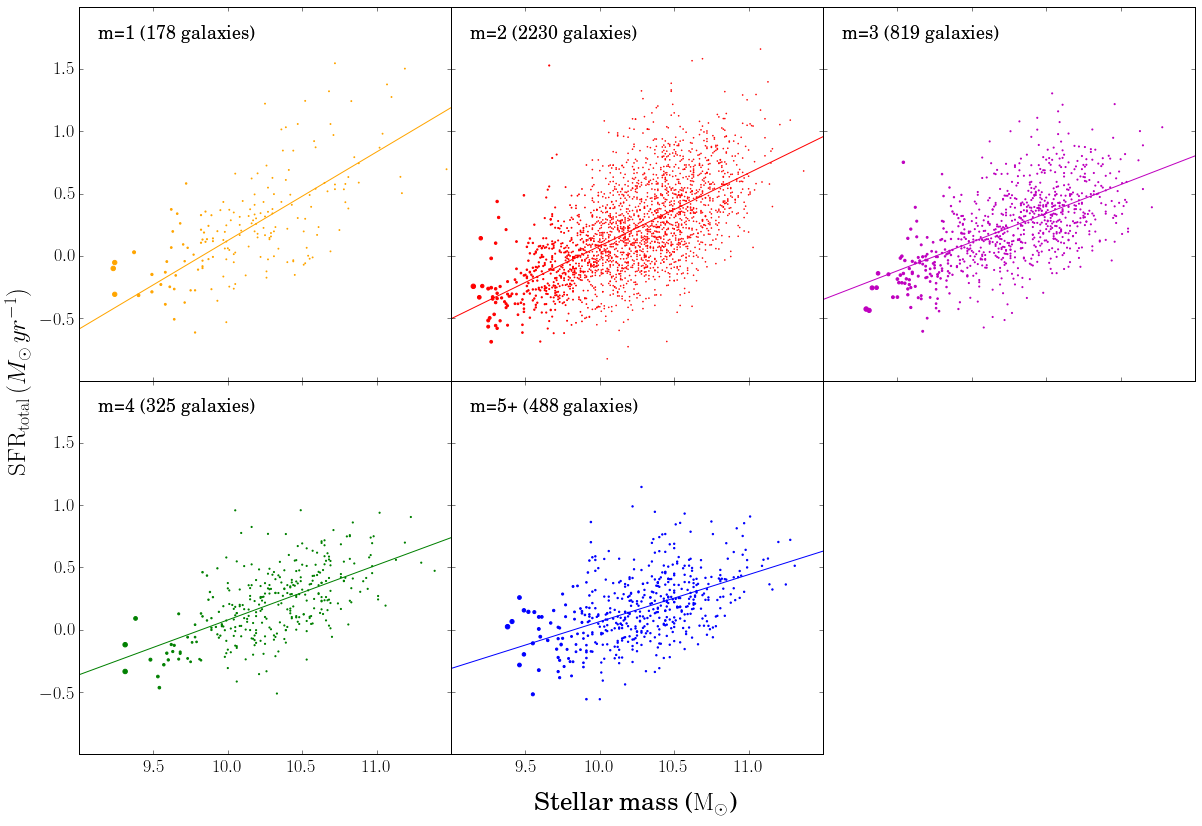

In [78]:
# Now plot a SFMS?

sf_sample = (in_sample*star_forming).astype(bool)

spiral_sf = (sf_sample*in_sample*ok_sfr).astype(bool)

nsa_sf = nsa_matched[spiral_sf]
arm_no = samples['m'][spiral_sf]
sfr_sf = sfrs['total'][spiral_sf]
mass_sf = chang_out_matched['lmass50_all'][spiral_sf]
weights = samples[spiral_sf]['mass_weighting']

m_labels = ['1','2','3','4','5+']

fig, axarr = plt.subplots(2,3,figsize=(20,13.4),sharex=True,sharey=True)
plt.subplots_adjust(hspace=0,wspace=0)
axarr = axarr.ravel()
fig.delaxes(axarr[-1])

colors_long = ['orange','r','m','g','b']

for m in range(5):
    ax = axarr[m]
    plt.sca(ax)
    in_m = arm_no == m
    mass, sfr, weighting = [s[in_m] for s in [mass_sf,sfr_sf,weights]]
    _ = plot_sfms(mass,sfr,weighting,color=colors_long[m])
    ax.text(0.05,0.95,'m={} ({} galaxies)'.format(m_labels[m],np.sum(in_m)),
            transform=ax.transAxes,ha='left',va='top')
    
fig.add_subplot(111, frameon=False)
# hide tick and tick label of the big axes
plt.tick_params(labelcolor='none', top='off', bottom='off', left='off', right='off')
plt.xlabel('Stellar mass ($\mathrm{M_\odot}$)',labelpad=20,fontsize=25)
plt.ylabel('$\mathrm{SFR_{total}} \, (M_\odot \, yr^{-1})$',labelpad=20,fontsize=25)

In [201]:
sfr = sfrs['total'] - chang_out_matched['lmass50_all']